In [36]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [37]:
# reading the csv file
df = pd.read_csv('DATA.csv')
print(df.shape)
df.head()

(147049, 5)


,user_id,order_id,time,service_id,basket
0,33,1,1/28/2016 15:33,1,12500
1,33,2,1/28/2016 22:23,1,33000
2,138,3,1/29/2016 19:27,1,40850
3,55,4,1/29/2016 20:17,1,27500
4,8,5,1/30/2016 14:06,1,32000


In [38]:
# checking the missing values in data
df.isnull().sum()

user_id       0
order_id      0
time          0
service_id    0
basket        0
dtype: int64

In [39]:
# Checking Dtype of coulmns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147049 entries, 0 to 147048
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     147049 non-null  int64 
 1   order_id    147049 non-null  int64 
 2   time        147049 non-null  object
 3   service_id  147049 non-null  int64 
 4   basket      147049 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 5.6+ MB


In [40]:
# Changing "time" column data type to "datetime"
df['time']= pd.to_datetime(df['time'])
max_time = df['time'].max()
print(max_time)

2020-12-18 23:42:00


In [41]:
# Grouping df by user_id
df2 = df.groupby(['user_id']).agg({'basket': sum , 'order_id' : lambda x:len(x) ,'time' : lambda x : (max_time - x.max()).days})
df2.head()

,basket,order_id,time
user_id,,,
1,67252275,1444,0
2,39750,2,704
3,1240015,25,56
4,248000,2,502
5,145800,5,1431


In [42]:
# renaming the coulmn's names
df2.rename(columns = {'time':'Recency','order_id':'Frequency','basket':'Monetary'} , inplace = True)
df2.head()

,Monetary,Frequency,Recency
user_id,,,
1,67252275,1444,0
2,39750,2,704
3,1240015,25,56
4,248000,2,502
5,145800,5,1431


In [43]:
# feature selection for the model
X = df2.iloc[:, :].values
X

array([[67252275,     1444,        0],
       [   39750,        2,      704],
       [ 1240015,       25,       56],
       ...,
       [   38000,        1,        0],
       [   73500,        1,        0],
       [  186504,        1,        0]], dtype=int64)

In [44]:
# scaling the X data
from sklearn import preprocessing
std_scaler = preprocessing.StandardScaler()
X = pd.DataFrame(std_scaler.fit_transform(X), columns = df2.iloc[:, :].columns)
X.head()


,Monetary,Frequency,Recency
0,20.342629,27.378556,-0.936521
1,-0.232777,-0.243423,1.218191
2,0.134654,0.197150,-0.765124
3,-0.169026,-0.243423,0.599936
4,-0.200312,-0.185957,3.443300


In [45]:
# using elbow method to determine number of clusters
from sklearn.cluster import KMeans
cost = []
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0,)
    kmeans.fit(X)
    cost.append(kmeans.inertia_)


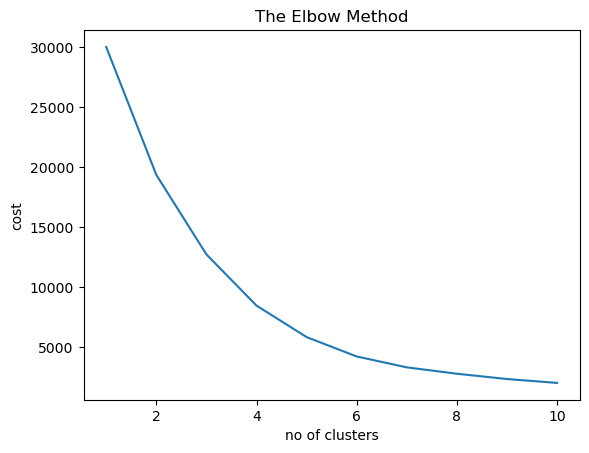

In [46]:
#Visualizing the ELBOW method to get the optimal value of K 
plt.plot(range(1,11), cost)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('cost')
plt.show()

In [47]:
# finally we got that k=4

kmeans_cluster = KMeans(n_clusters = 4, init='k-means++', random_state=0)
kmeans_cluster_pred = kmeans_cluster.fit_predict(X)
kmeans_cluster_pred

array([1, 2, 0, ..., 0, 0, 0])

In [48]:
# centroids of clusters
kmeans_cluster.cluster_centers_

array([[-0.05490081, -0.0528323 , -0.55362843],
       [19.0698154 , 17.78910543, -0.93322539],
       [-0.21524536, -0.22775289,  1.11606182],
       [ 3.43974083,  3.62906556, -0.83157871]])

In [49]:
pd.DataFrame(kmeans_cluster.cluster_centers_, columns = X.columns)

,Monetary,Frequency,Recency
0,-0.054901,-0.052832,-0.553628
1,19.069815,17.789105,-0.933225
2,-0.215245,-0.227753,1.116062
3,3.439741,3.629066,-0.831579


In [50]:
labels = kmeans_cluster.labels_
X['labels'] = kmeans_cluster.labels_
X.groupby('labels').count()

,Monetary,Frequency,Recency
labels,,,
0,6372,6372,6372
1,13,13,13
2,3373,3373,3373
3,240,240,240


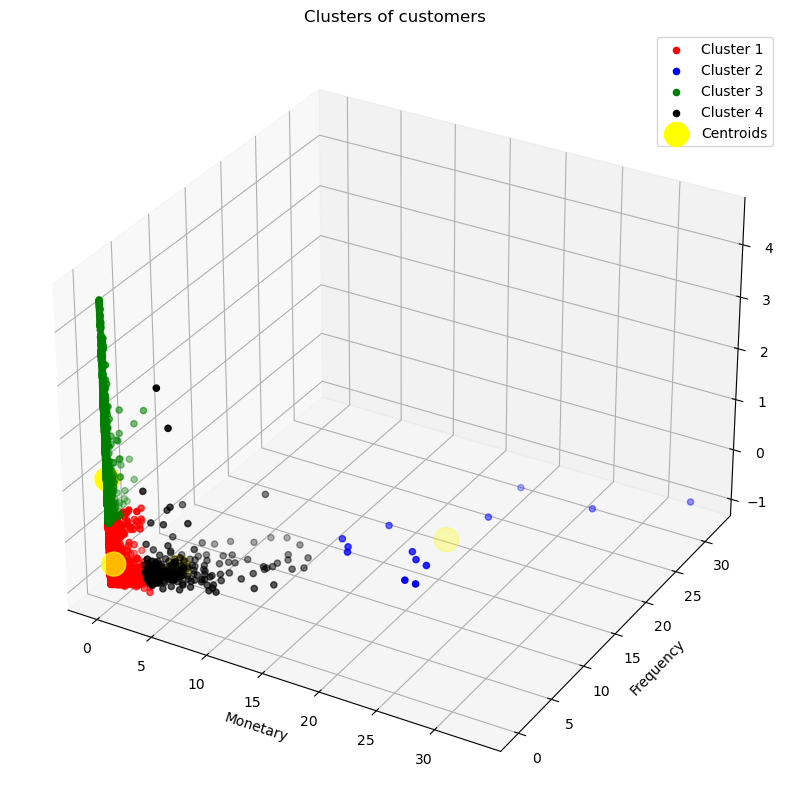

In [53]:
#Visualizing all the clusters 
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')

ax.scatter3D(X.iloc[kmeans_cluster_pred == 0, 0], X.iloc[kmeans_cluster_pred == 0, 1], X.iloc[kmeans_cluster_pred == 0, 2], \
             label = 'Cluster 1', c = 'red' )

ax.scatter3D(X.iloc[kmeans_cluster_pred == 1, 0], X.iloc[kmeans_cluster_pred == 1, 1], X.iloc[kmeans_cluster_pred == 1, 2], \
             label = 'Cluster 2', c = 'blue')

ax.scatter3D(X.iloc[kmeans_cluster_pred == 2, 0], X.iloc[kmeans_cluster_pred == 2, 1], X.iloc[kmeans_cluster_pred == 2, 2], \
             label = 'Cluster 3', c = 'green')

ax.scatter3D(X.iloc[kmeans_cluster_pred == 3, 0], X.iloc[kmeans_cluster_pred == 3, 1], X.iloc[kmeans_cluster_pred == 3, 2], \
             label = 'Cluster 4', c = 'black')


ax.scatter3D(kmeans_cluster.cluster_centers_[:, 0], kmeans_cluster.cluster_centers_[:, 1], kmeans_cluster.cluster_centers_[:, 2]\
            ,s = 300, c = 'yellow', label = 'Centroids')

plt.title('Clusters of customers')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.legend()
plt.show()
